# Demo For Face Detection
### BlazeFace (mediapipe/modules/face_detection/face_detection_short_range.tflite)

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torchvision as tv

from blaze.face_detection import FaceDetection
from detect_result import DetectResult

Run `face_detection_short_range_map.py` to generate converted pytorch checkpoint.
Once done, you will find `model/face_detection_short_range.pth` and `model/face_detection_short_range.onnx`.

Create a `FaceDetection` object and load checkpoint generated.

In [2]:
FaceDetection.IMAGE_NORMALIZE = True

detector = FaceDetection()
state = torch.load('model/face_detection_short_range.pth', map_location='cpu')
detector.load_state_dict(state, strict=True)

<All keys matched successfully>

Load an image which should be resized to `128x128`. Call detector forward method and it outputs a predicted score vector and a box regressor.

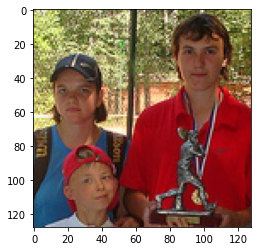

In [3]:
image = tv.io.image.read_image('data/1.jpg')
plt.imshow(image.numpy().transpose([1, 2, 0]))

In [4]:
scores, boxes = detector(image[None])

Now you need to perform non-maximum-supression (NMS) to those detected results.
Use the object `DetectResult`.

In [5]:
filter = DetectResult(FaceDetection.NUM_CLASSES, FaceDetection.NUM_COORDS, 0.5, 0.3)
scores, boxes = filter(scores, boxes)

scores = scores.cpu().detach().numpy()
boxes = boxes.cpu().detach().numpy() * 128
print(scores)
print(boxes)

[[0.95282644]
 [0.9372135 ]
 [0.92361146]]
[[ 25.642056  54.378407  27.296309  27.2962    17.261559  48.643337
   29.07967   48.09812   21.650377  54.610603  22.570534  59.87965
   13.456694  50.971283  39.151577  50.339622]
 [ 35.78203  106.61487   21.693039  21.692972  33.41955  100.83552
   43.262657 100.33461   40.938763 105.31958   40.28774  110.47299
   24.37394  104.48142   45.30923  102.91092 ]
 [ 98.29479   31.876394  30.216753  30.216665  91.383484  25.756105
  103.998856  25.880472  97.22602   33.523064  97.3862    39.087437
   84.76009   27.477797 111.71158   27.76596 ]]


Now display the result on input image.

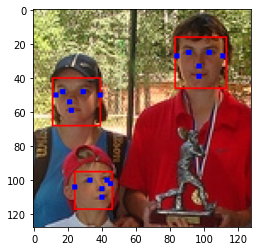

In [7]:
cv_img = cv.imread('data/1.jpg')
for box in boxes:
    box, points = box[:4].reshape([2, 2]), box[4:].reshape([-1, 2])
    lt = box[0] - box[1] / 2
    rb = box[0] + box[1] / 2
    cv_img = cv.rectangle(cv_img, lt.astype('int32'), rb.astype('int32'), color=(0, 0, 255), thickness=1)
    for pts in points:
        cv_img = cv.drawMarker(cv_img, pts.astype('int32'), (255, 0, 0), markerType=2, markerSize=3)
# convert BGR to RGB
plt.figure()
plt.imshow(cv_img[..., ::-1])
plt.show()